In [1]:
from itertools import islice

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import pandas as pd
from sklearn.manifold import TSNE

In [3]:
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.torch.distributions import NegativeBinomialOutput

from pytorch_lightning.loggers import CSVLogger
from datasets import load_dataset

from estimator import TFTEstimator

In [4]:
dataset = get_dataset("wiki-rolling_nips")

In [5]:
estimator = TFTEstimator(
        freq=dataset.metadata.freq,
        prediction_length=dataset.metadata.prediction_length,
        context_length=dataset.metadata.prediction_length,
        
        scaling=True,
        num_feat_static_cat=len(dataset.metadata.feat_static_cat),
        cardinality=[int(cat_feat_info.cardinality) for cat_feat_info in dataset.metadata.feat_static_cat],
        
        distr_output=NegativeBinomialOutput(),
        
        batch_size=256,
        num_batches_per_epoch=200,
        trainer_kwargs=dict(gpus="1", max_epochs=100, logger=CSVLogger(".", "lightning_logs/")),
    )

In [6]:
predictor = estimator.train(
        training_data=dataset.train,
        shuffle_buffer_length=1024,
        num_workers=8,
        cache_data=True,
    )

/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus='1')` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices='1')` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_ze

Training: 0it [00:00, ?it/s]

Epoch 0, global step 200: 'train_loss' reached 8.69927 (best 8.69927), saving model to './lightning_logs/version_46/checkpoints/epoch=0-step=200.ckpt' as top 1
Epoch 1, global step 400: 'train_loss' reached 8.31990 (best 8.31990), saving model to './lightning_logs/version_46/checkpoints/epoch=1-step=400.ckpt' as top 1
Epoch 2, global step 600: 'train_loss' was not in top 1
Epoch 3, global step 800: 'train_loss' was not in top 1
Epoch 4, global step 1000: 'train_loss' reached 8.20523 (best 8.20523), saving model to './lightning_logs/version_46/checkpoints/epoch=4-step=1000.ckpt' as top 1
Epoch 5, global step 1200: 'train_loss' was not in top 1
Epoch 6, global step 1400: 'train_loss' was not in top 1
Epoch 7, global step 1600: 'train_loss' was not in top 1
Epoch 8, global step 1800: 'train_loss' reached 8.13480 (best 8.13480), saving model to './lightning_logs/version_46/checkpoints/epoch=8-step=1800.ckpt' as top 1
Epoch 9, global step 2000: 'train_loss' reached 8.12777 (best 8.12777), s

Epoch 92, global step 18600: 'train_loss' was not in top 1
Epoch 93, global step 18800: 'train_loss' was not in top 1
Epoch 94, global step 19000: 'train_loss' was not in top 1
Epoch 95, global step 19200: 'train_loss' was not in top 1
Epoch 96, global step 19400: 'train_loss' reached 7.66149 (best 7.66149), saving model to './lightning_logs/version_46/checkpoints/epoch=96-step=19400.ckpt' as top 1
Epoch 97, global step 19600: 'train_loss' reached 7.65619 (best 7.65619), saving model to './lightning_logs/version_46/checkpoints/epoch=97-step=19600.ckpt' as top 1
Epoch 98, global step 19800: 'train_loss' reached 7.64622 (best 7.64622), saving model to './lightning_logs/version_46/checkpoints/epoch=98-step=19800.ckpt' as top 1
Epoch 99, global step 20000: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'model' is an instance of `nn.Module

In [7]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor,
)

In [8]:
forecasts = list(forecast_it)

In [9]:
tss = list(ts_it)

In [10]:
evaluator = Evaluator()

In [11]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 47675it [00:00, 98204.13it/s]


In [12]:
agg_metrics

{'MSE': 431839437.5540534,
 'abs_error': 1497767969.0,
 'abs_target_sum': 4139290389.0,
 'abs_target_mean': 2894.1027016255903,
 'seasonal_error': 759.9957754325233,
 'MASE': 1.5660744171042167,
 'MAPE': 0.5378745856593485,
 'sMAPE': 0.28677677568983434,
 'MSIS': 32.36383614317314,
 'QuantileLoss[0.1]': 440774354.40000004,
 'Coverage[0.1]': 0.029557070442230375,
 'QuantileLoss[0.2]': 756634070.0000001,
 'Coverage[0.2]': 0.07917077434015032,
 'QuantileLoss[0.3]': 1019171337.0000001,
 'Coverage[0.3]': 0.15499947561615102,
 'QuantileLoss[0.4]': 1260494017.6000001,
 'Coverage[0.4]': 0.25912253102604443,
 'QuantileLoss[0.5]': 1497767969.0,
 'Coverage[0.5]': 0.38656668414612827,
 'QuantileLoss[0.6]': 1706940523.6,
 'Coverage[0.6]': 0.5143408495018352,
 'QuantileLoss[0.7]': 1913551538.2000003,
 'Coverage[0.7]': 0.6568208355182661,
 'QuantileLoss[0.8]': 2065471280.3999999,
 'Coverage[0.8]': 0.7854920468449573,
 'QuantileLoss[0.9]': 2048190745.2,
 'Coverage[0.9]': 0.8877315154693237,
 'RMSE': 2

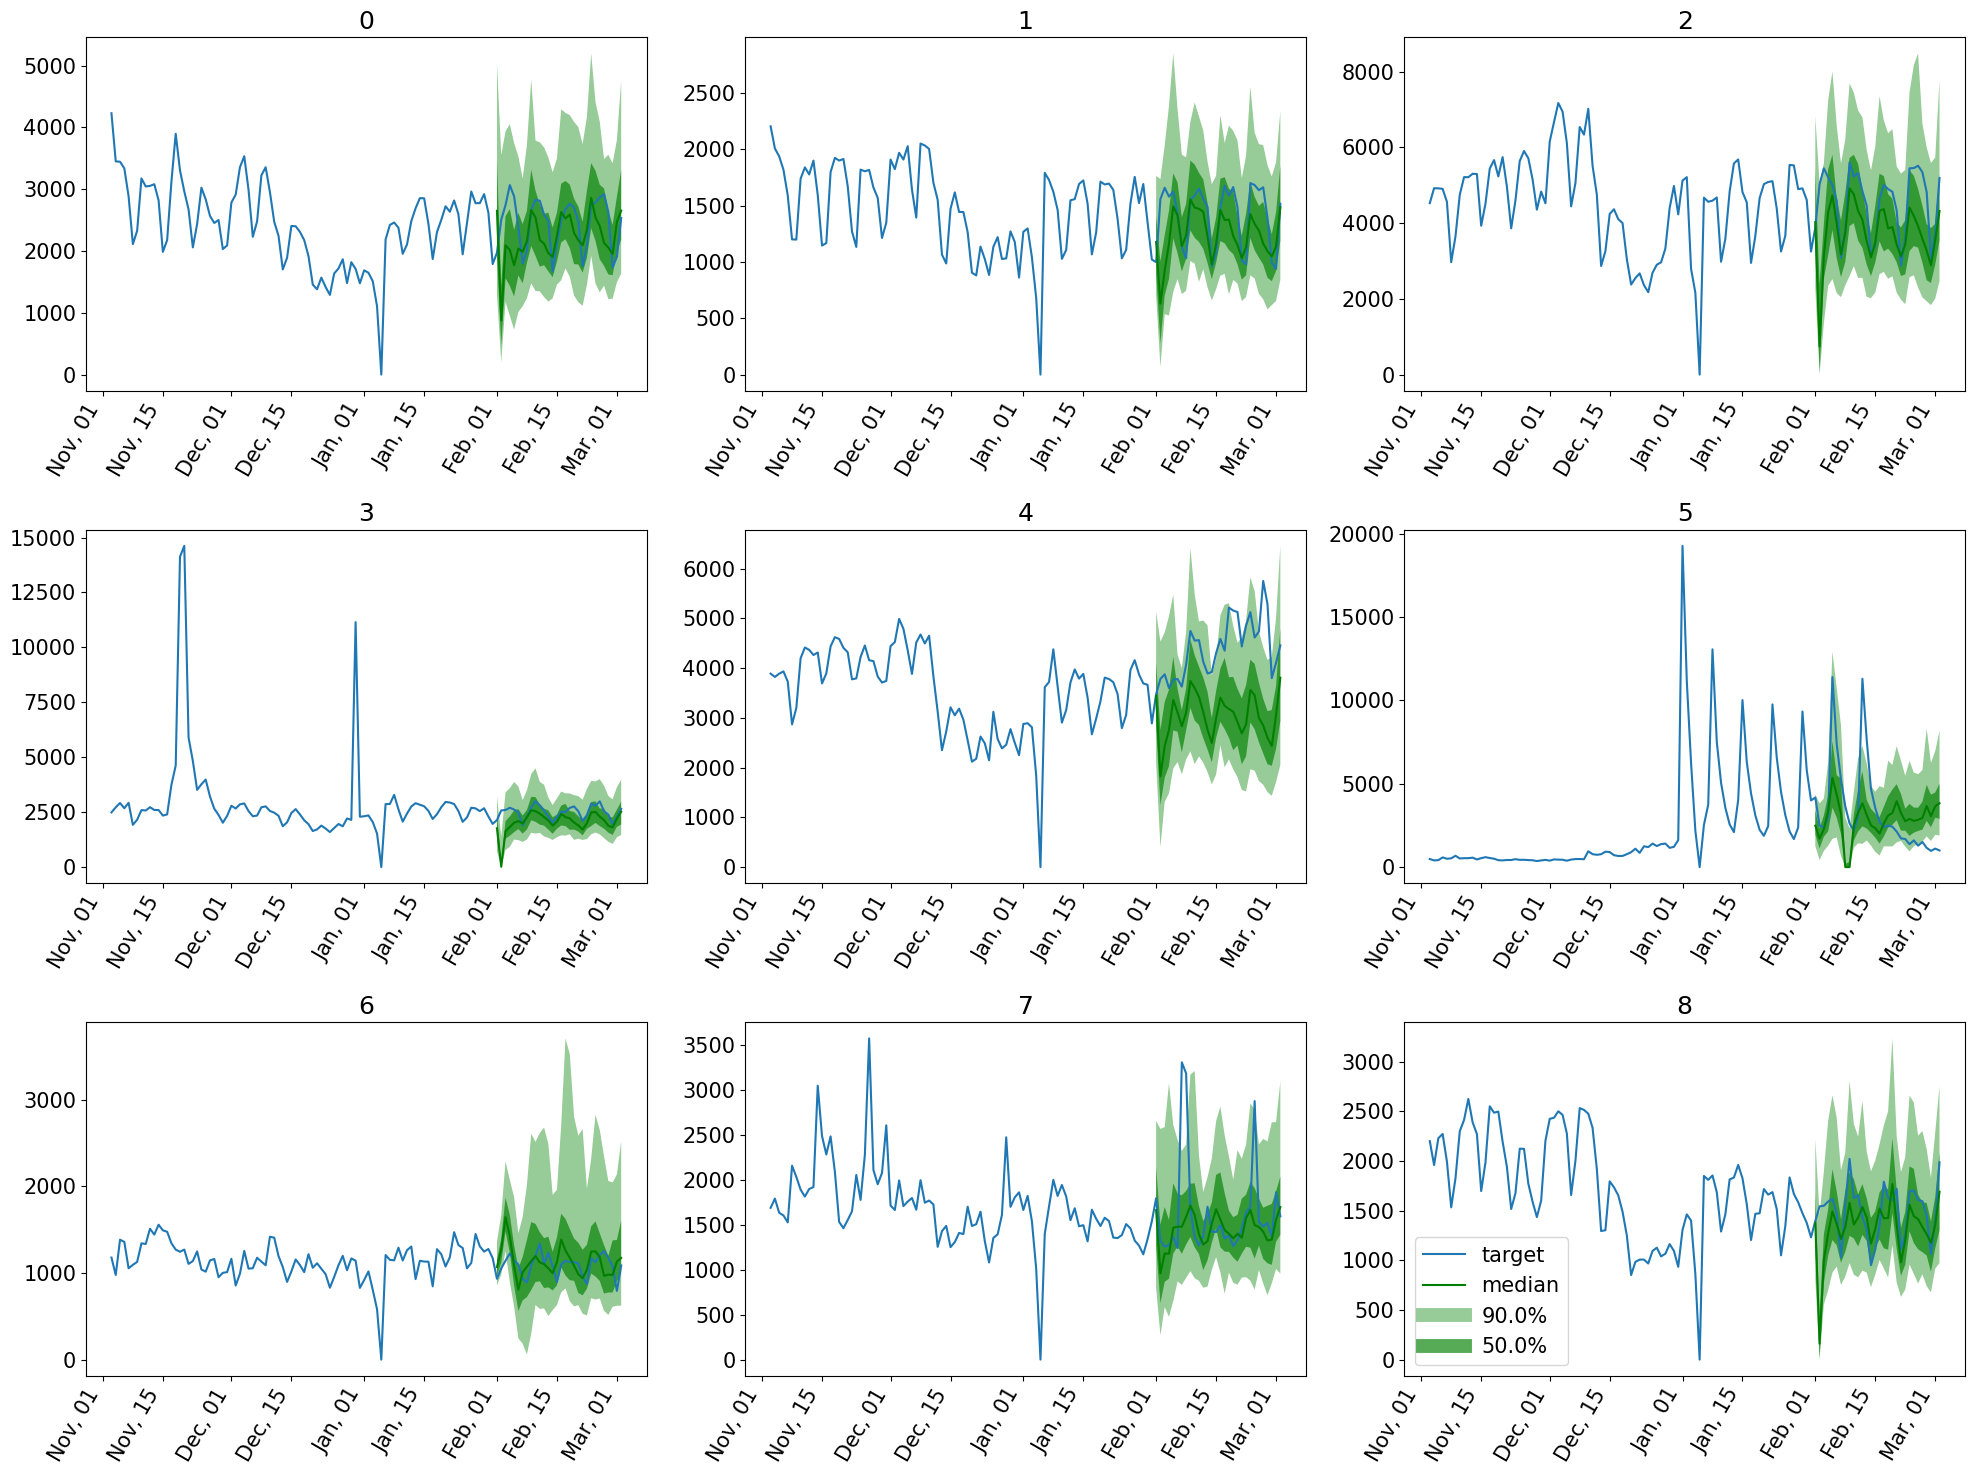

In [13]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [18]:
metrics = pd.read_csv("lightning_logs/version_86/metrics.csv")

In [19]:
metrics

,train_perplexity,epoch,step,val_loss,train_loss
0,2.042362,0,49,NaN,NaN
1,2.050069,0,99,NaN,NaN
2,2.743227,0,149,NaN,NaN
3,2.440984,0,199,NaN,NaN
4,NaN,0,199,4.355846,NaN
...,...,...,...,...,...
295,80.659866,49,9899,NaN,NaN
296,82.568138,49,9949,NaN,NaN
297,81.211136,49,9999,NaN,NaN
298,NaN,49,9999,1.084462,NaN


Text(0, 0.5, 'perplexity')

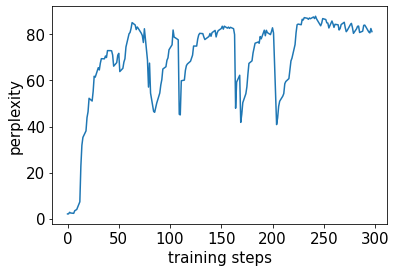

In [20]:
ax = metrics.train_perplexity.dropna().plot(kind="line")
ax.set_xlabel("training steps")
ax.set_ylabel("perplexity")

Text(0, 0.5, 'val neg. log likelihood')

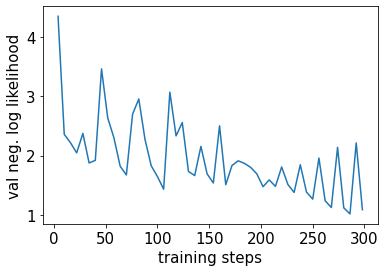

In [21]:
ax = metrics.val_loss.dropna().plot()
ax.set_xlabel("training steps")
ax.set_ylabel("val neg. log likelihood")

In [22]:
X = predictor.prediction_net.vq_vae.embed.cpu()

In [23]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)

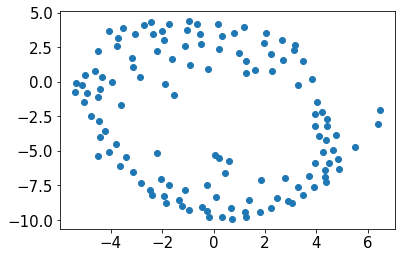

In [24]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], alpha=1.0)